In [749]:
import math
import numpy as np
import os

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set()
sns.set_style("ticks")
sns.set_context("paper")
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [750]:
three_d_points = np.array([
    [-0.08, -2.30333333, 1.19666667],  # Top right solar panel
    [-0.15666667, -0.84333333, 1.19666667],  # Top left solar panel
    [-0.08, -2.30333333, -0.78333333],  # Bottom right solar panel
    [-0.15666667, -0.84333333, -0.78333333],  # Bottom left solar panel
    [-0.24333333, 1.03, -0.65333333],  # Bottom left satellite
])

three_d_points_names = [
    'Top right solar panel',
    'Top left solar panel',
    'Bottom right solar panel',
    'Bottom left solar panel',
    'Bottom left satellite'
]


def get_rotated_point(roll, pitch, yaw, point=None):
    if point is None:
        point = [-0.08, -2.30333333, 1.19666667]

    r_roll = np.array([[1, 0, 0],
                       [0, math.cos(roll / 180 * math.pi), -math.sin(roll / 180 * math.pi)],
                       [0, math.sin(roll / 180 * math.pi), math.cos(roll / 180 * math.pi)]])

    r_pitch = np.array([[math.cos(pitch / 180 * math.pi), 0, math.sin(pitch / 180 * math.pi)],
                        [0, 1, 0],
                        [-math.sin(pitch / 180 * math.pi), 0, math.cos(pitch / 180 * math.pi)]])

    r_yaw = np.array([[math.cos(yaw / 180 * math.pi), -math.sin(yaw / 180 * math.pi), 0],
                      [math.sin(yaw / 180 * math.pi), math.cos(yaw / 180 * math.pi), 0],
                      [0, 0, 1]])

    rotation_matrix = r_yaw @ r_pitch @ r_roll

    rotated_3d_points = np.dot(rotation_matrix, point)

    return rotated_3d_points

In [751]:
folder = "../test_images/dynamic_unknowndeg_0to360_5degstep/"
suffixes = ['_linefit_eps2']
colors = ['red', 'green', 'blue']
nice_suffixes = [s.removeprefix("_").replace('_', ' ').capitalize() for s in suffixes]


In [752]:
df_true = pd.read_csv(folder + "real_scores.csv")
df_true = df_true.rename(columns={'correct_roll': 'roll', 'correct_pitch': 'pitch', 'correct_yaw':
    'yaw'})
df_true['img_number'] = df_true.index
df_true['suffix'] = 'true'
df_true

,roll,pitch,yaw,img_number,suffix
0,127.970000,-79.560000,-44.000000,0,true
1,123.295573,-78.244572,-44.152291,1,true
2,119.068439,-76.935369,-44.763274,2,true
3,115.161870,-75.638750,-45.707437,3,true
4,111.491226,-74.359729,-46.901282,4,true
...,...,...,...,...,...
68,157.623186,-84.620406,-54.433702,68,true
69,147.366750,-83.432329,-48.971823,69,true
70,139.573127,-82.170727,-45.978678,70,true
71,133.288987,-80.872993,-44.502381,71,true


In [753]:
df_guess = pd.read_csv(folder + "guesses_linefit_eps2.csv")
df_guess

,img_number,roll,pitch,yaw,x,y,z,roll_min,roll_max,pitch_min,pitch_max,yaw_min,yaw_max,x_min,x_max,y_min,y_max,z_min,z_max
0,0,0.000000,-89.550000,79.000000,0.000000,0.000000,0.000000,-64.000000,64.000000,-121.550000,-57.550000,47.000000,111.000000,-1.600000,1.600000,-1.600000,1.600000,-1.600000,1.600000
1,1,0.000000,-89.550000,79.000000,0.000000,0.000000,0.000000,-88.000000,88.000000,-133.550000,-45.550000,35.000000,123.000000,-2.200000,2.200000,-2.200000,2.200000,-2.200000,2.200000
2,2,-18.277729,-115.004070,99.257843,0.223378,0.114417,-0.292200,-26.277729,-10.277729,-119.004070,-111.004070,95.257843,103.257843,0.023378,0.423378,-0.085583,0.314417,-0.492200,-0.092200
3,3,-19.584925,-115.335725,95.257843,0.235663,0.137549,-0.272570,-27.584925,-11.584925,-119.335725,-111.335725,91.257843,99.257843,0.035663,0.435663,-0.062451,0.337549,-0.472570,-0.072570
4,4,-21.734955,-115.796453,92.270346,0.232172,0.149174,-0.419060,-29.734955,-13.734955,-119.796453,-111.796453,88.270346,96.270346,0.032172,0.432172,-0.050826,0.349174,-0.619060,-0.219060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,139,-723.397257,-111.277706,114.901109,0.188329,0.057061,-0.191728,-730.024959,-716.769555,-112.198728,-110.356683,108.103484,121.698733,0.171071,0.205588,0.046822,0.067301,-0.424994,0.041538
140,140,-725.098148,-113.424772,111.682624,0.174954,0.057047,-0.403642,-731.054066,-719.142230,-114.483476,-112.366069,105.553905,117.811344,0.155996,0.193911,0.047373,0.066721,-0.633667,-0.173617
141,141,-730.094985,-114.717122,111.923802,0.195132,0.052849,-0.273681,-734.234169,-725.955801,-115.770772,-113.663473,107.589187,116.258417,0.172703,0.217560,0.041506,0.064192,-0.527141,-0.020222
142,142,-731.108297,-115.618246,107.718377,0.191923,0.069293,-0.342846,-734.977271,-727.239322,-116.694475,-114.542017,103.618450,111.818305,0.169611,0.214235,0.056307,0.082279,-0.590518,-0.095175


In [754]:
df = pd.read_csv(folder + "fine_scores_linefit_eps2.csv")
df

,img_number,iterations,loss,roll,pitch,yaw,x,y,z
0,0,1904,1.735185e+02,26.215003,-57.550000,63.036350,0.042279,0.222542,-1.600000
1,1,574,1.904264e+00,-18.277729,-115.004070,99.257843,0.223378,0.114417,-0.292200
2,2,413,2.410220e-01,-19.584925,-115.335725,95.257843,0.235663,0.137549,-0.272570
3,3,889,4.610998e-10,-21.734955,-115.796453,92.270346,0.232172,0.149174,-0.419060
4,4,518,1.374141e+00,-29.017048,-116.600528,94.841751,0.238481,0.123581,-0.418679
...,...,...,...,...,...,...,...,...,...
139,139,602,1.016420e-07,-720.342260,-112.122806,111.890931,0.175576,0.050846,-0.349199
140,140,623,5.084181e-02,-725.937475,-113.430892,112.721144,0.193911,0.047373,-0.234289
141,141,441,9.246833e-10,-727.550047,-114.358815,109.148867,0.191567,0.062954,-0.292814
142,142,322,2.377740e+00,-728.317322,-114.542017,104.967768,0.195889,0.082279,-0.226976


In [755]:
df_guess

,img_number,roll,pitch,yaw,x,y,z,roll_min,roll_max,pitch_min,pitch_max,yaw_min,yaw_max,x_min,x_max,y_min,y_max,z_min,z_max
0,0,0.000000,-89.550000,79.000000,0.000000,0.000000,0.000000,-64.000000,64.000000,-121.550000,-57.550000,47.000000,111.000000,-1.600000,1.600000,-1.600000,1.600000,-1.600000,1.600000
1,1,0.000000,-89.550000,79.000000,0.000000,0.000000,0.000000,-88.000000,88.000000,-133.550000,-45.550000,35.000000,123.000000,-2.200000,2.200000,-2.200000,2.200000,-2.200000,2.200000
2,2,-18.277729,-115.004070,99.257843,0.223378,0.114417,-0.292200,-26.277729,-10.277729,-119.004070,-111.004070,95.257843,103.257843,0.023378,0.423378,-0.085583,0.314417,-0.492200,-0.092200
3,3,-19.584925,-115.335725,95.257843,0.235663,0.137549,-0.272570,-27.584925,-11.584925,-119.335725,-111.335725,91.257843,99.257843,0.035663,0.435663,-0.062451,0.337549,-0.472570,-0.072570
4,4,-21.734955,-115.796453,92.270346,0.232172,0.149174,-0.419060,-29.734955,-13.734955,-119.796453,-111.796453,88.270346,96.270346,0.032172,0.432172,-0.050826,0.349174,-0.619060,-0.219060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,139,-723.397257,-111.277706,114.901109,0.188329,0.057061,-0.191728,-730.024959,-716.769555,-112.198728,-110.356683,108.103484,121.698733,0.171071,0.205588,0.046822,0.067301,-0.424994,0.041538
140,140,-725.098148,-113.424772,111.682624,0.174954,0.057047,-0.403642,-731.054066,-719.142230,-114.483476,-112.366069,105.553905,117.811344,0.155996,0.193911,0.047373,0.066721,-0.633667,-0.173617
141,141,-730.094985,-114.717122,111.923802,0.195132,0.052849,-0.273681,-734.234169,-725.955801,-115.770772,-113.663473,107.589187,116.258417,0.172703,0.217560,0.041506,0.064192,-0.527141,-0.020222
142,142,-731.108297,-115.618246,107.718377,0.191923,0.069293,-0.342846,-734.977271,-727.239322,-116.694475,-114.542017,103.618450,111.818305,0.169611,0.214235,0.056307,0.082279,-0.590518,-0.095175


In [756]:
def plot_guess(guess_type, df=df_guess):
    sns.lineplot(data=df, x='img_number', y=guess_type, color='blue', ci=None)
    sns.lineplot(data=df, x='img_number', y=guess_type + '_min', color='red', ci=None)
    sns.lineplot(data=df, x='img_number', y=guess_type + '_max', color='green', ci=None)
    sns.scatterplot(data=df, x='img_number', y=guess_type, color='black')
    plt.legend(['Guess', 'Min', 'Max', 'Lowest loss estimate'])
    plt.title('SMA ' + guess_type + ' guesses')
    plt.xlabel('Image number')
    plt.ylabel(guess_type + ' (deg)')
    plt.show()

In [757]:
df_guess_mod = df_guess.copy()
# df_guess['roll'] go from -180 to 180
df_guess_mod['roll'] = df_guess['roll'] % 360 - 180
# pitch goes from 0 - 180 to -90 - 90
df_guess_mod['pitch'] = df_guess['pitch'] % 360 - 180
df_guess_mod['yaw'] = df_guess['yaw'] % 360 - 180

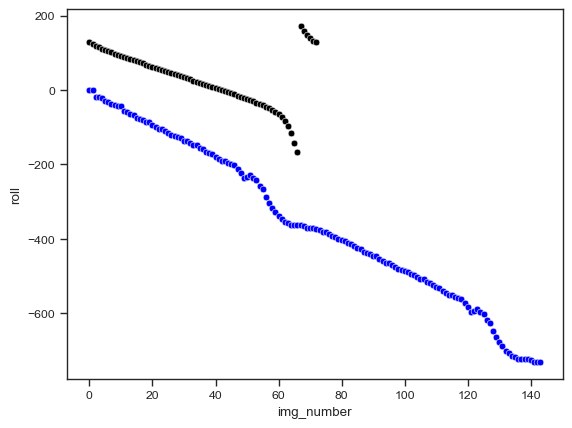

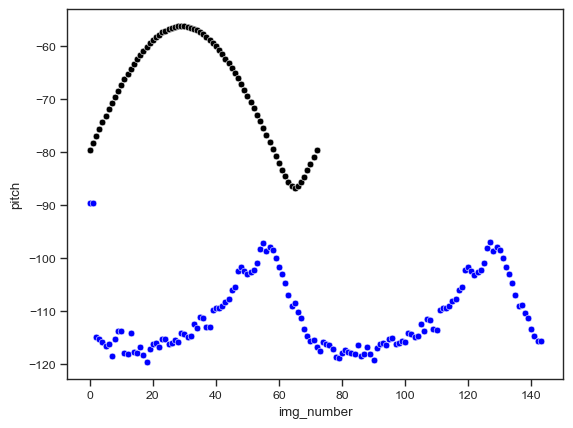

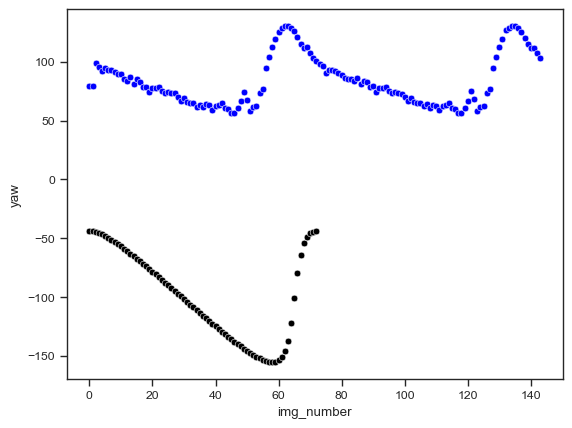

In [758]:
for guess_type in ['roll', 'pitch', 'yaw']:
    sns.scatterplot(data=df_true, x='img_number', y=guess_type, color='black')
    sns.scatterplot(data=df_guess, x='img_number', y=guess_type, color='blue')
    plt.show()

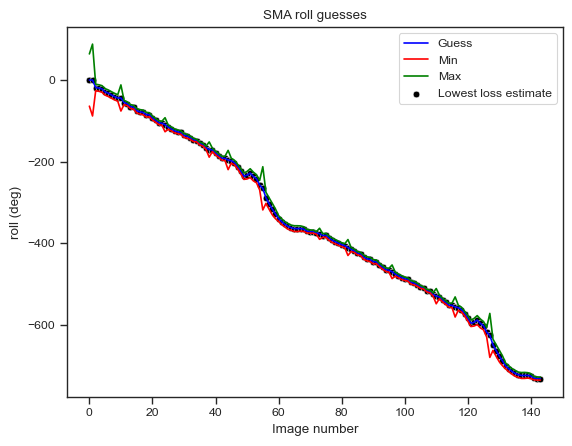

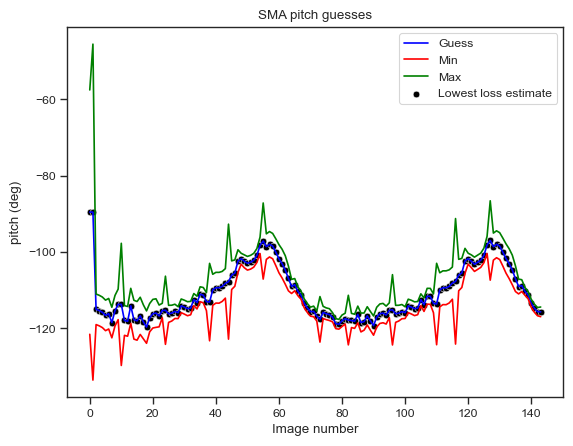

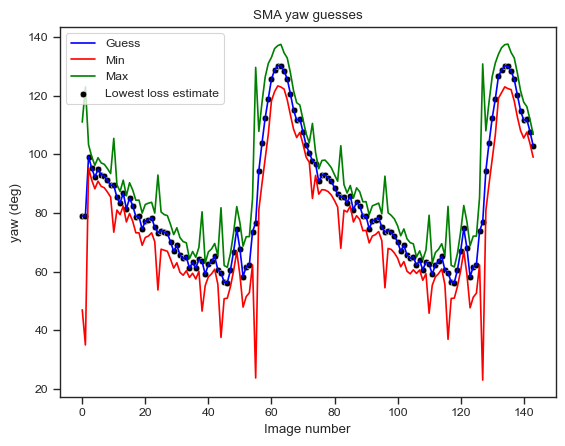

In [759]:
for guess_type in ['roll', 'pitch', 'yaw']:
    plot_guess(guess_type)

In [760]:
# def plot_reg(guess_type):
#     sns.regplot(data=df_guess, x='true_' + guess_type, y='guess_' + guess_type, ci=None)
#     plt.show()

In [761]:
# for guess_type in ['roll', 'pitch', 'yaw']:
#     plot_reg(guess_type)

In [762]:
df_rotated_points = pd.DataFrame()
for i, point in enumerate(three_d_points):
    df_local = df.apply(
        lambda row: get_rotated_point(row['roll'], row['pitch'], row['yaw'], point),
        axis=1, result_type='expand').rename(columns={0: 'x', 1: 'y', 2: 'z'})
    df_local['img_number'] = df['img_number']
    df_local['3d_point'] = three_d_points_names[i]
    df_rotated_points = pd.concat([df_local, df_rotated_points])

In [763]:
df_rotated_points.to_csv(folder + 'rotated_points.csv', index=False)

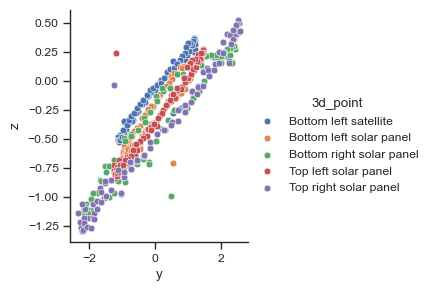

In [764]:
sns.FacetGrid(df_rotated_points, hue='3d_point').map(sns.scatterplot, 'y', 'z').add_legend()

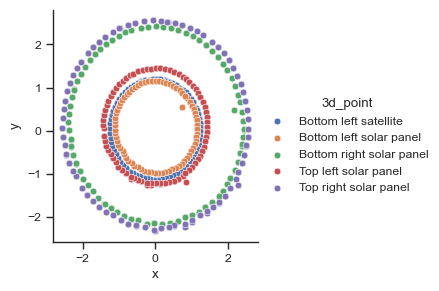

In [765]:
sns.FacetGrid(df_rotated_points, hue='3d_point').map(sns.scatterplot, 'x', 'y').add_legend()

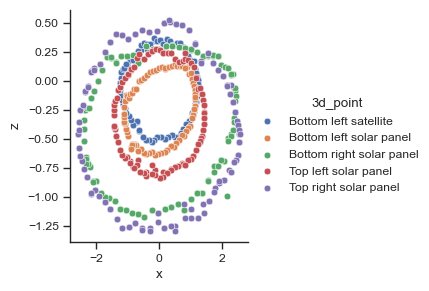

In [766]:
sns.FacetGrid(df_rotated_points, hue='3d_point').map(sns.scatterplot, 'x', 'z').add_legend()